## Import Data ##

In [448]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from scipy.stats import *
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [450]:
image_path = []
labels = []

for i in os.listdir("/Users/jay/Jupyter Projects/LaLigaLogos/Laliga teams"):
    for label in os.listdir(f"/Users/jay/Jupyter Projects/LaLigaLogos/Laliga teams/{i}"):
        for image in os.listdir(f"/Users/jay/Jupyter Projects/LaLigaLogos/Laliga teams/{i}"):
            image_path.append(f"/Users/jay/Jupyter Projects/LaLigaLogos/Laliga teams/{i}/{image}")
            labels.append(i)

df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
df = df.drop_duplicates().reset_index(drop=True)
df

,image_path,labels
0,/Users/jay/Jupyter Projects/LaLigaLogos/Laliga...,Barcelona
1,/Users/jay/Jupyter Projects/LaLigaLogos/Laliga...,Barcelona
2,/Users/jay/Jupyter Projects/LaLigaLogos/Laliga...,Barcelona
3,/Users/jay/Jupyter Projects/LaLigaLogos/Laliga...,Barcelona
4,/Users/jay/Jupyter Projects/LaLigaLogos/Laliga...,Barcelona
...,...,...
1995,/Users/jay/Jupyter Projects/LaLigaLogos/Laliga...,Real Sociedad
1996,/Users/jay/Jupyter Projects/LaLigaLogos/Laliga...,Real Sociedad
1997,/Users/jay/Jupyter Projects/LaLigaLogos/Laliga...,Real Sociedad
1998,/Users/jay/Jupyter Projects/LaLigaLogos/Laliga...,Real Sociedad


## Statistical Modeling ##

Shape:  (2000, 2)

Counts:
 labels
Barcelona           100
Rayo Vallecano      100
Getafe              100
Athletic Bilbao     100
Atletico Madrid     100
Leganes             100
Sevilla             100
Celta Vigo          100
Girona              100
Real Madrid         100
Real Betis          100
Osasuna             100
Villarreal          100
Real Valladolid     100
Espanyol            100
Las Palmas          100
Deportivo Alaves    100
Mallorca            100
Valencia            100
Real Sociedad       100
Name: count, dtype: int64



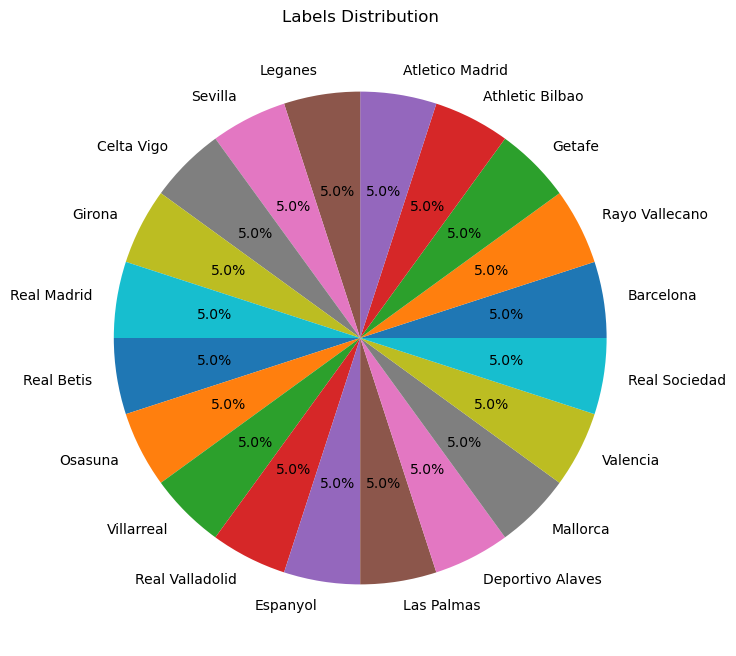

In [453]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["labels"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["labels"].value_counts(), labels = df["labels"].value_counts().index, autopct="%1.1f%%")
plt.title("Labels Distribution")
plt.show()

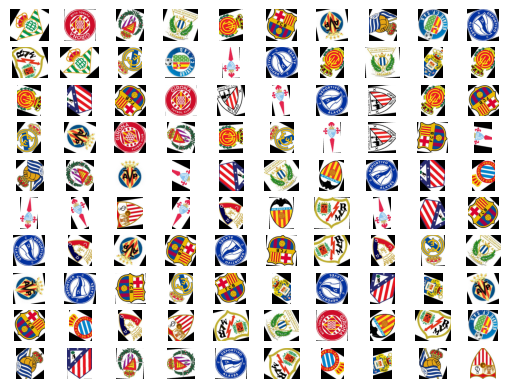

In [455]:
#100 random images
n_rows = 10
n_cols = 10

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()

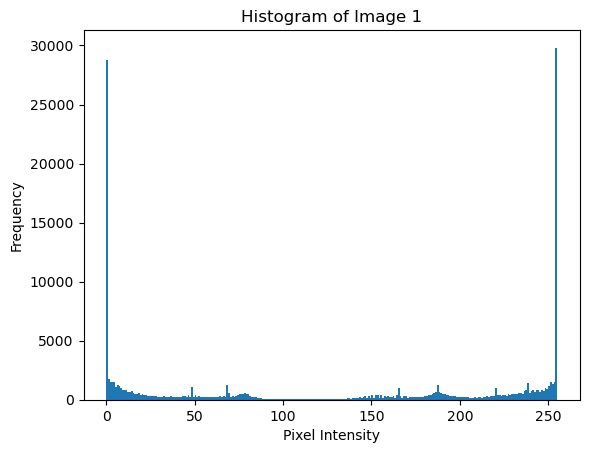

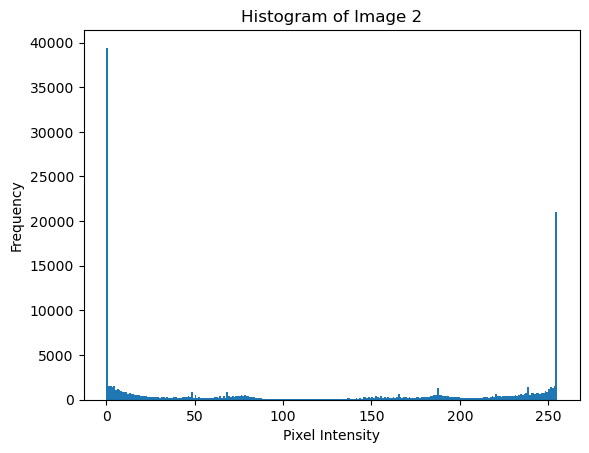

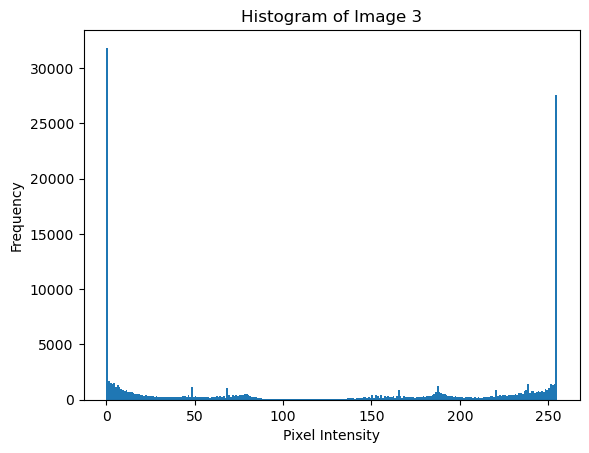

In [457]:
for i in range(0, 3):
    plt.figure()
    
    img_data = np.array(Image.open(df.iloc[i, 0])).ravel()
    
    plt.hist(img_data, bins=range(256))
    
    plt.title(f"Histogram of Image {i+1}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.show()

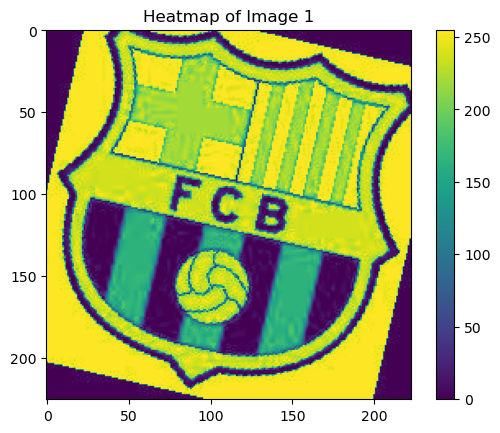

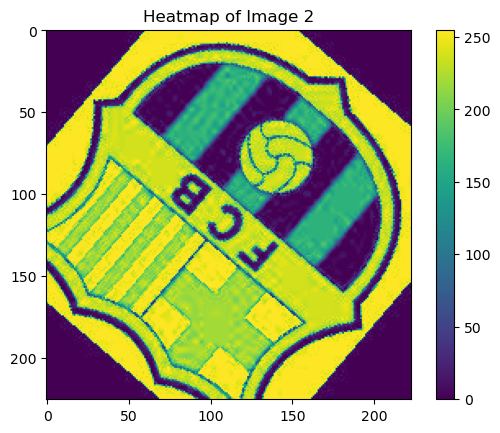

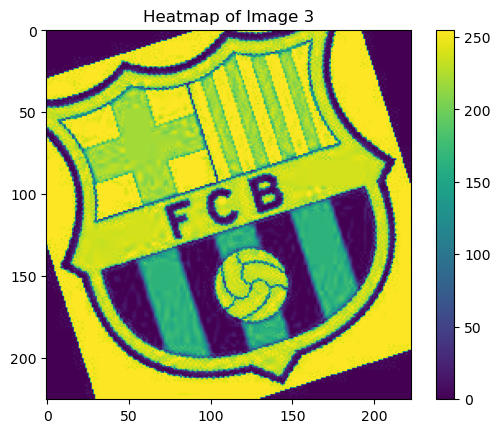

In [459]:
for i in range(0, 3):
    plt.figure()

    img_data = np.array(Image.open(df.iloc[i, 0]))

    cax = plt.imshow(img_data, cmap="viridis", interpolation="nearest")

    plt.title(f"Heatmap of Image {i+1}")

    plt.colorbar(cax)

    plt.imshow(img_data[:, :, 0])

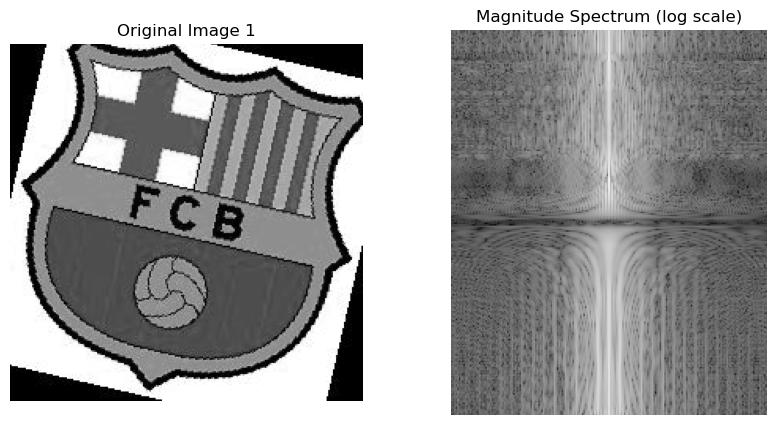

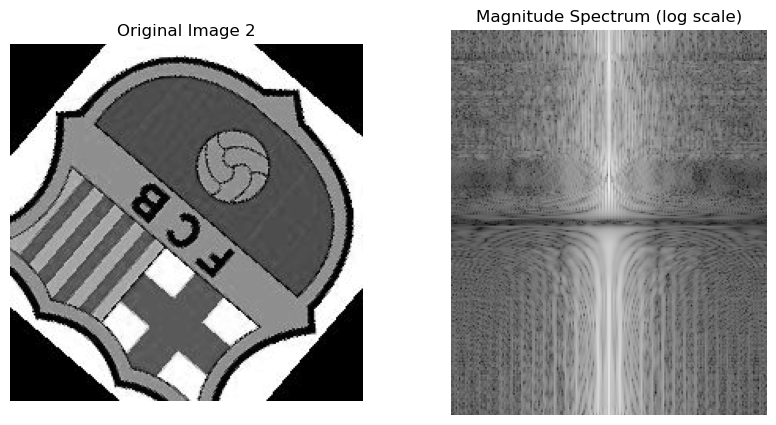

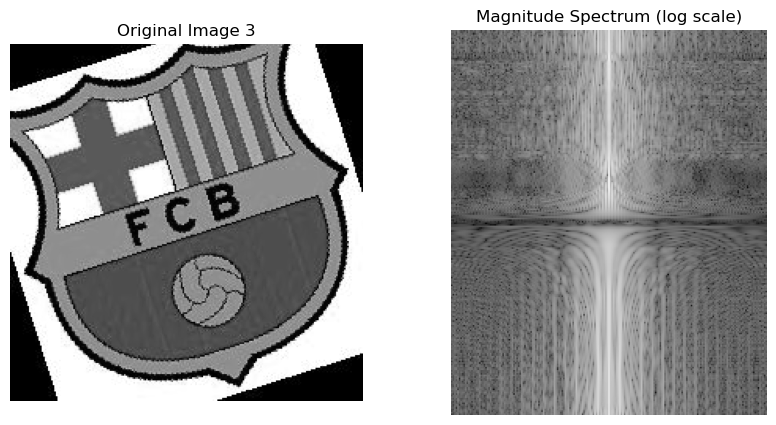

In [461]:
for i in range(0, 3):
    img_data = plt.imread(df.iloc[0+i, 0])
    
    if len(img_data.shape) == 3:
        img_data = np.mean(img_data, axis=2)
    
    ft = np.fft.fft2(image)
    
    ft_shifted = np.fft.fftshift(ft)
    
    magnitude_spectrum = np.abs(ft_shifted)
    
    magnitude_spectrum_log = np.log1p(magnitude_spectrum)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_data, cmap="gray")
    plt.title(f"Original Image {i+1}")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum_log[:, :, 0], cmap="gray")
    plt.title("Magnitude Spectrum (log scale)")
    plt.axis("off")
    
    plt.show()

## Training Model ##

In [463]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(1400, 2)
(300, 2)
(300, 2)


In [465]:
le = LabelEncoder()
le.fit(df["labels"])

transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=False)
])

In [467]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(le.transform(dataframe["labels"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [469]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

In [471]:
LR = 1e-4
BATCH_SIZE = 2
EPOCHS = 10

In [473]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [485]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((32*64*64), 32)

        self.output = nn.Linear(32, len(df["labels"].unique()))

    def forward(self, x):
        x = self.conv1(x) #(32, 128, 128)
        x = self.pooling(x) #(32, 64, 64)
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [487]:
model = Net().to(device)

In [489]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─ReLU: 1-3                              --
├─Flatten: 1-4                           --
├─Linear: 1-5                            4,194,336
├─Linear: 1-6                            660
Total params: 4,195,892
Trainable params: 4,195,892
Non-trainable params: 0

In [493]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [495]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

Epoch no. 1/10 
    Training Loss: 0.5438 
    Training Accuracy: 83.0714 
    Validation Loss: 0.0039 
    Validation Accuracy: 100.0
Epoch no. 2/10 
    Training Loss: 0.0039 
    Training Accuracy: 100.0 
    Validation Loss: 0.0018 
    Validation Accuracy: 100.0
Epoch no. 3/10 
    Training Loss: 0.0018 
    Training Accuracy: 100.0 
    Validation Loss: 0.0012 
    Validation Accuracy: 100.0
Epoch no. 4/10 
    Training Loss: 0.001 
    Training Accuracy: 100.0 
    Validation Loss: 0.0009 
    Validation Accuracy: 100.0
Epoch no. 5/10 
    Training Loss: 0.0006 
    Training Accuracy: 100.0 
    Validation Loss: 0.0006 
    Validation Accuracy: 100.0
Epoch no. 6/10 
    Training Loss: 0.0004 
    Training Accuracy: 100.0 
    Validation Loss: 0.0005 
    Validation Accuracy: 100.0
Epoch no. 7/10 
    Training Loss: 0.0002 
    Training Accuracy: 100.0 
    Validation Loss: 0.0004 
    Validation Accuracy: 100.0
Epoch no. 8/10 
    Training Loss: 0.0002 
    Training Accuracy: 10

In [496]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 100.0 
Loss: 0.0001


## Post-Training Analysis ##

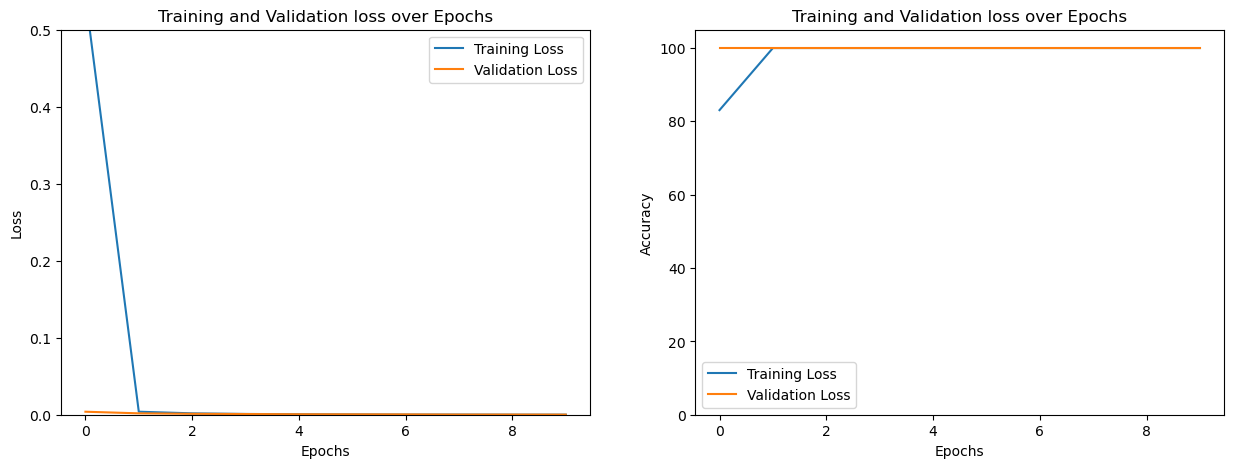

In [499]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.5])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,105])
axs[1].legend()

plt.show()

In [501]:
torch.save(model.state_dict(), "model.pth")

In [503]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("model.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=131072, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=20, bias=True)
)

In [505]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    
    model_prediction = loaded_model(image.unsqueeze(0))
    model_prediction = torch.argmax(model_prediction, axis = 1).item()
    
    return le.inverse_transform([model_prediction])

['Real Betis']


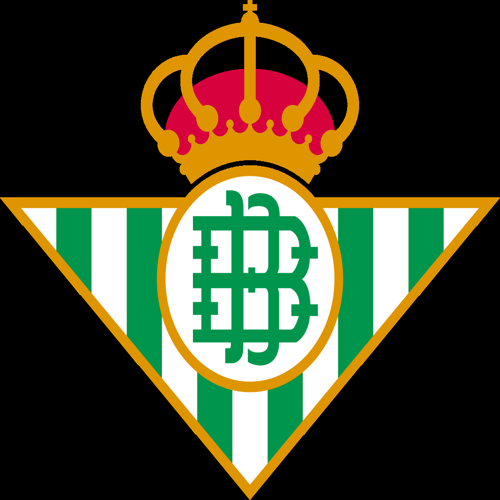

In [507]:
path1 = "/Users/jay/Jupyter Projects/LaLigaLogos/Betis.png"
print(predict_image(path1))
Image.open(path1).convert("RGB").resize([500, 500])

['Sevilla']


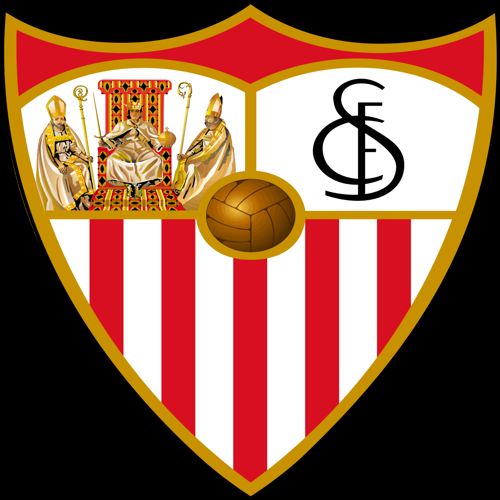

In [509]:
path2 = "/Users/jay/Jupyter Projects/LaLigaLogos/Sevilla.png"
print(predict_image(path2))
Image.open(path2).convert("RGB").resize([500, 500])